In [1]:
import yfinance as yf
import pandas as pd
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import dimod
from prettytable import PrettyTable
from tqdm import tqdm
from neal import SimulatedAnnealingSampler

plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', markersize=16)
plt.rc('axes', grid=False)
warnings.filterwarnings('ignore')

/var/folders/sm/lw2bbffs15g5l3r4ldd25hc00000gn/T/ipykernel_45638/718790637.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [2]:
class DataFetcher:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.price_data = self.fetch_data_for_tickers()
        self.returns_data = self.calculate_returns()
        self.correlation_matrix = self.calculate_correlations()

    def fetch_data(self, ticker):
        stock_data = yf.Ticker(ticker)
        return stock_data.history(period='1d', start=self.start_date, end=self.end_date)['Close']

    def fetch_data_for_tickers(self):
        price_data = {}
        for ticker in tqdm(self.tickers, desc="Fetching Data"):
            price_data[ticker] = self.fetch_data(ticker)
        return pd.DataFrame(price_data)

    def calculate_returns(self):
        return self.price_data.pct_change().dropna()

    def calculate_correlations(self):
        return self.returns_data.corr()

In [3]:
class Graph:
    def __init__(self, correlation_matrix, threshold=0.5):
        self.correlation_matrix = correlation_matrix
        self.adjacency_matrix = self.create_adjacency_matrix(threshold)

    def create_adjacency_matrix(self, threshold):
        adjacency_matrix = (self.correlation_matrix.abs() > threshold).astype(int)
        np.fill_diagonal(adjacency_matrix.values, 0)
        return adjacency_matrix

    def visualize(self):
        G = nx.from_pandas_adjacency(self.adjacency_matrix)
        shells = [list(G.nodes)]
        pos = nx.shell_layout(G, shells)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title("Graph of Assets", fontsize=20)
        ax.set_xticks([])
        ax.set_yticks([])
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', alpha=0.5, label='Assets')
        nx.draw_networkx_edges(G, pos, width=1, alpha=0.3, edge_color='lightgrey')
        nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
        plt.savefig("graph_of_assets.pdf", bbox_inches='tight')
        plt.show()

In [4]:
class QUBOSolver:
    def __init__(self, adjacency_matrix, expected_returns, penalty_parameter):
        self.H = self.construct_hamiltonian(adjacency_matrix, expected_returns, penalty_parameter)

    def construct_hamiltonian(self, adjacency_matrix, expected_returns, penalty_parameter):
        n = len(expected_returns)
        H = np.zeros((n, n))
        adjacency_matrix_np = adjacency_matrix.values

        for i in range(n):
            H[i, i] -= expected_returns[i]

        for i in range(n):
            for j in range(n):
                if adjacency_matrix_np[i, j] == 1:
                    H[i, j] += penalty_parameter

        return H

    def solve(self):
        sampler = SimulatedAnnealingSampler()
        response = sampler.sample_qubo(self.H, num_reads=100)
        solution = response.first.sample
        return solution

In [5]:
def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    tables = pd.read_html(url)
    sp500_df = tables[0]
    return sp500_df['Symbol'].tolist()


def select_random_tickers(tickers, count=20):
    return random.sample(tickers, count)


def calculate_expected_returns(price_data):
    return price_data.mean()

In [6]:
print("Fetching S&P 500 tickers...")
sp500_tickers = get_sp500_tickers()
print("Selecting random tickers...")
random_tickers = select_random_tickers(sp500_tickers)

print("Fetching and processing data...")
data_fetcher = DataFetcher(random_tickers, "2002-01-01", "2022-12-31")
expected_returns = calculate_expected_returns(data_fetcher.price_data)

Fetching S&P 500 tickers...
Selecting random tickers...
Fetching and processing data...


Fetching Data: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


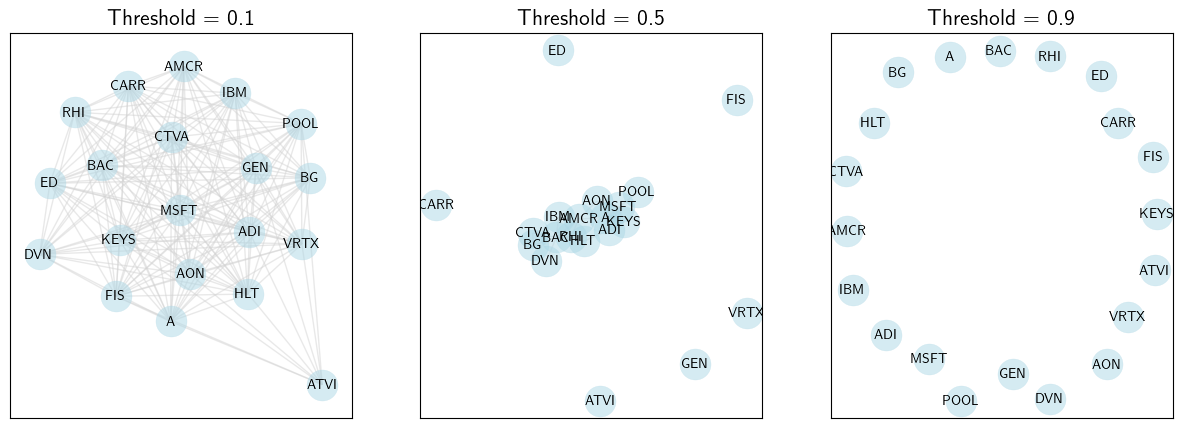

In [7]:
# Visualize graph of assets in case threshold is 0.1, 0.5, 0.9
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
thresholds = [0.1, 0.5, 0.9]
for i, threshold in enumerate(thresholds):
    graph = Graph(data_fetcher.correlation_matrix, threshold=threshold)
    G = nx.from_pandas_adjacency(graph.adjacency_matrix)
    #shells = [list(G.nodes)]
    #pos = nx.shell_layout(G, shells)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', alpha=0.5, ax=ax[i])
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color='lightgrey', ax=ax[i])
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', ax=ax[i])
    ax[i].set_title(f"Threshold = {threshold}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.savefig("graph_of_assets.pdf", bbox_inches='tight')
plt.show()

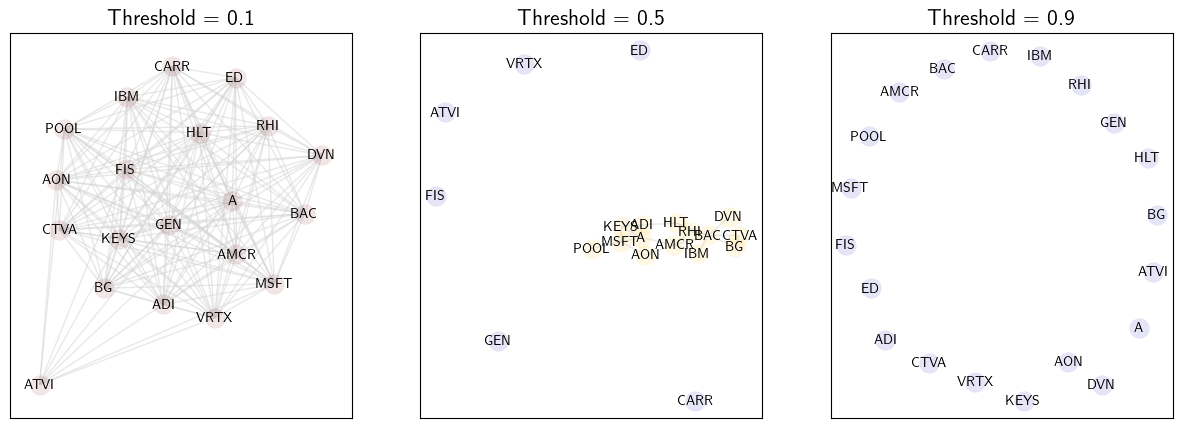

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
thresholds = [0.1, 0.5, 0.9]
for i, threshold in enumerate(thresholds):
    graph = Graph(data_fetcher.correlation_matrix, threshold=threshold)
    G = nx.from_pandas_adjacency(graph.adjacency_matrix)
    shells = [list(G.nodes)]
    #pos = nx.shell_layout(G, shells)
    pos = nx.spring_layout(G)
    connected_components = list(nx.connected_components(G))
    for component in connected_components:
        nx.draw_networkx_nodes(G, pos, nodelist=component, node_size=200, alpha=0.1, ax=ax[i],
                               node_color=plt.cm.jet(len(component) / len(G.nodes)))

    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color='lightgrey', ax=ax[i])
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', ax=ax[i], font_weight='bold')
    ax[i].set_title(f"Threshold = {threshold}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.savefig("example2.pdf", bbox_inches='tight')
plt.show()

Constructing the graph of assets...


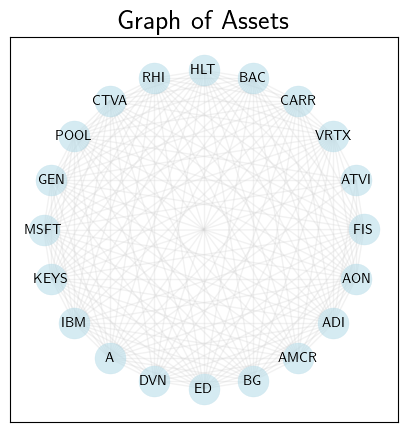

Constructing Hamiltonian and solving QUBO...
Solution: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 1, 19: 0}
Selected assets: [0, 1, 2, 9, 12, 15, 18]
Number of selected assets: 7
Selected assets names: ['MSFT', 'KEYS', 'IBM', 'AON', 'VRTX', 'HLT', 'POOL']
+--------+------+----------+
| Ticker | Name | Selected |
+--------+------+----------+
|   0    | MSFT |   Yes    |
|   1    | KEYS |   Yes    |
|   2    | IBM  |   Yes    |
|   3    |  A   |    No    |
|   4    | DVN  |    No    |
|   5    |  ED  |    No    |
|   6    |  BG  |    No    |
|   7    | AMCR |    No    |
|   8    | ADI  |    No    |
|   9    | AON  |   Yes    |
|   10   | FIS  |    No    |
|   11   | ATVI |    No    |
|   12   | VRTX |   Yes    |
|   13   | CARR |    No    |
|   14   | BAC  |    No    |
|   15   | HLT  |   Yes    |
|   16   | RHI  |    No    |
|   17   | CTVA |    No    |
|   18   | POOL |   Yes    |
|   19   | GEN  |    No    |

In [9]:
print("Constructing the graph of assets...")
graph = Graph(data_fetcher.correlation_matrix, threshold=0.1)
graph.visualize()

print("Constructing Hamiltonian and solving QUBO...")
qubo_solver = QUBOSolver(graph.adjacency_matrix, expected_returns, penalty_parameter=5.0)
solution = qubo_solver.solve()
print("Solution:", solution)

# From solution dictionary, visualize the selected assets
selected_assets = []
for key, value in solution.items():
    if value == 1:
        selected_assets.append(key)
print("Selected assets:", selected_assets)
print("Number of selected assets:", len(selected_assets))

# Print out name of selected assets
selected_assets_names = []
for ticker in selected_assets:
    selected_assets_names.append(data_fetcher.price_data.columns[ticker])
print("Selected assets names:", selected_assets_names)

# Table for all assets and selected assets
table = PrettyTable()
table.field_names = ["Ticker", "Name", "Selected"]
for i in range(len(data_fetcher.price_data.columns)):
    table.add_row([i, data_fetcher.price_data.columns[i], "Yes" if i in selected_assets else "No"])
print(table)

In [10]:
from scipy.optimize import minimize

class MeanVarianceOptimizer:
    def __init__(self, returns_data, risk_free_rate=0.01):
        self.returns_data = returns_data
        self.mean_returns = returns_data.mean()
        self.cov_matrix = returns_data.cov()
        self.risk_free_rate = risk_free_rate

    def objective(self, weights):
        portfolio_return = np.sum(self.mean_returns * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        return - (portfolio_return - self.risk_free_rate) / portfolio_volatility  # Minimize negative Sharpe ratio

    def optimize(self):
        num_assets = len(self.mean_returns)
        args = ()
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
        bounds = [(0,1) for asset in range(num_assets)]
        initial_weights = [1./num_assets for asset in range(num_assets)]

        solution = minimize(self.objective, initial_weights, args=args, bounds=bounds, constraints=constraints)
        return solution.x

In [11]:
print("\nMean Variance Optimization...")
mvo = MeanVarianceOptimizer(data_fetcher.returns_data)
mvo_weights = mvo.optimize()
mvo_selected_assets = [i for i, weight in enumerate(mvo_weights) if
                       weight > 0.01]  # Threshold to consider asset as selected

print("MVO Selected assets:", mvo_selected_assets)
print("Number of MVO selected assets:", len(mvo_selected_assets))

# Print out name of MVO selected assets
mvo_selected_assets_names = []
for ticker in mvo_selected_assets:
    mvo_selected_assets_names.append(data_fetcher.price_data.columns[ticker])
print("MVO Selected assets names:", mvo_selected_assets_names)

# Update the table to include MVO selections
table = PrettyTable()
table.field_names = ["Ticker", "Name", "QUBO Selected", "MVO Selected"]
for i in range(len(data_fetcher.price_data.columns)):
    table.add_row([i, data_fetcher.price_data.columns[i], "Yes" if i in selected_assets else "No",
                   "Yes" if i in mvo_selected_assets else "No"])
print(table)


Mean Variance Optimization...
MVO Selected assets: [4]
Number of MVO selected assets: 1
MVO Selected assets names: ['DVN']
+--------+------+---------------+--------------+
| Ticker | Name | QUBO Selected | MVO Selected |
+--------+------+---------------+--------------+
|   0    | MSFT |      Yes      |      No      |
|   1    | KEYS |      Yes      |      No      |
|   2    | IBM  |      Yes      |      No      |
|   3    |  A   |       No      |      No      |
|   4    | DVN  |       No      |     Yes      |
|   5    |  ED  |       No      |      No      |
|   6    |  BG  |       No      |      No      |
|   7    | AMCR |       No      |      No      |
|   8    | ADI  |       No      |      No      |
|   9    | AON  |      Yes      |      No      |
|   10   | FIS  |       No      |      No      |
|   11   | ATVI |       No      |      No      |
|   12   | VRTX |      Yes      |      No      |
|   13   | CARR |       No      |      No      |
|   14   | BAC  |       No      |      No  

In [12]:
def portfolio_metrics(weights, returns_data, cov_matrix, risk_free_rate=0.01):
    weights = np.array(weights)  # Convert weights to a numpy array
    # Portfolio Return
    port_return = np.sum(returns_data.mean() * weights)
    # Portfolio Volatility (Risk)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # Sharpe Ratio
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    return port_return, port_volatility, sharpe_ratio

In [13]:
# Metrics for QUBO
cov_matrix = data_fetcher.returns_data.cov()
qubo_weights = [solution[i] for i in range(len(solution))]
qubo_return, qubo_volatility, qubo_sharpe = portfolio_metrics(qubo_weights, data_fetcher.returns_data, cov_matrix)
# Metrics for MVO
mvo_return, mvo_volatility, mvo_sharpe = portfolio_metrics(mvo_weights, data_fetcher.returns_data, cov_matrix)

# Display the results
metrics_table = PrettyTable()
metrics_table.field_names = ["Metric", "QUBO", "MVO"]
metrics_table.add_row(["Portfolio Return", f"{qubo_return:.2%}", f"{mvo_return:.2%}"])
metrics_table.add_row(["Portfolio Volatility", f"{qubo_volatility:.2%}", f"{mvo_volatility:.2%}"])
metrics_table.add_row(["Sharpe Ratio", f"{qubo_sharpe:.2f}", f"{mvo_sharpe:.2f}"])
print(metrics_table)

+----------------------+-------+-------+
|        Metric        |  QUBO |  MVO  |
+----------------------+-------+-------+
|   Portfolio Return   | 0.72% | 0.42% |
| Portfolio Volatility | 9.93% | 3.96% |
|     Sharpe Ratio     | -0.03 | -0.15 |
+----------------------+-------+-------+
